## Initial Local Creation of Bayesian Network

## HC + BDs

The experimentation and testing of the initial simple Bayesian Network on a smaller dataset for testing

In [2]:
import pgmpy
import pandas as pd
import networkx as nx
from matplotlib import pyplot as plt
import numpy as np
import sys
sys.path.insert(0,"..")
from Data.DataPreprocessing import DataPreprocessing as myData
from pgmpy import estimators
from pgmpy.inference import VariableElimination
from sklearn.metrics import f1_score, accuracy_score, roc_curve, precision_score, recall_score, roc_auc_score, balanced_accuracy_score
from pgmpy.metrics import correlation_score, log_likelihood_score, structure_score
print(np.__version__)

c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.26.1


### Data importing and preprocessing

In [8]:

loaded_data = myData.load_data(num_rows = 100)
#display(loaded_data)
data = myData.preprocess_data(loaded_data)
train_data, test_data = myData.split_data(data)

c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: ConvergenceWarning: Number of distinct clusters (49) found smaller than n_clusters (50). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(
c:\Users\zachs\AppData\Local\Programs\Python\Python

### Structure Learning

In [9]:
scoring_method = estimators.BDsScore(data=train_data,equivalent_sample_size=10) # TODO change sample size hyperparameter
est = estimators.HillClimbSearch(data=train_data, use_cache = True)
estimated_model = est.estimate(
    scoring_method=scoring_method, max_iter=int(1e2))
model = pgmpy.models.BayesianNetwork(estimated_model.edges())
print(model.nodes())
print(model.edges())

 82%|████████▏ | 82/100 [19:53<04:21, 14.55s/it]

['funded_amnt', 'loan_amnt', 'funded_amnt_inv', 'term', 'num_tl_op_past_12m', 'int_rate', 'sub_grade', 'grade', 'emp_title', 'avg_cur_bal', 'max_bal_bc', 'total_rec_int', 'total_bc_limit', 'dti', 'total_il_high_credit_limit', 'revol_bal', 'tot_hi_cred_lim', 'bc_open_to_buy', 'all_util', 'revol_util', 'mo_sin_old_il_acct', 'annual_inc', 'bc_util', 'mo_sin_old_rev_tl_op', 'last_pymnt_amnt', 'total_bal_ex_mort', 'addr_state', 'home_ownership', 'emp_length', 'mort_acc', 'verification_status', 'last_credit_pull_d', 'loan_status', 'out_prncp', 'recoveries', 'purpose', 'title', 'delinq_2yrs', 'inq_last_6mths', 'fico_range_high', 'fico_range_low', 'mths_since_recent_inq', 'chargeoff_within_12_mths', 'inq_last_12m', 'open_acc', 'num_sats', 'pub_rec', 'tax_liens', 'pub_rec_bankruptcies', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_bal_il', 'installment', 'total_rec_late_fee', 'initial_list_status', 'collection_recovery_fee', 'debt_settlement_flag', 'last_pymnt_d'

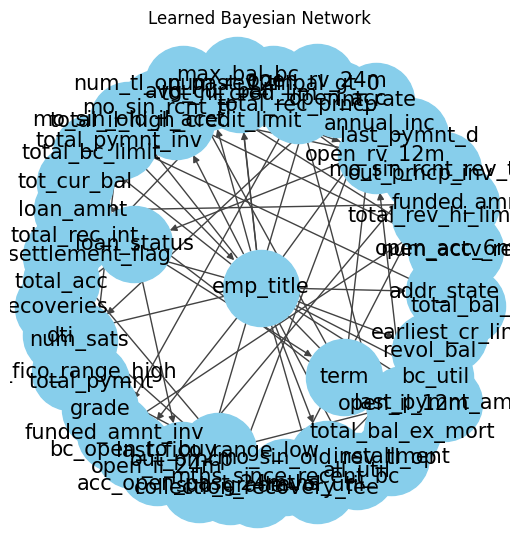

In [10]:
active_trail_nodes = model.active_trail_nodes('loan_status')['loan_status']
active_trail_nodes_list = list(active_trail_nodes)
original_nodes = list(model.nodes())
for node in original_nodes:
    if node not in active_trail_nodes_list:
        model.remove_node(node)
        

nx_graph = nx.DiGraph(model.edges())
pos = nx.spring_layout(nx_graph,2)
plt.figure(figsize=(5, 5))
nx.draw(nx_graph, pos, with_labels=True, node_size=3000, node_color = 'skyblue', edge_color='#424242',font_size=15,font_color='black')
plt.title('Learned Bayesian Network')
plt.show()

###  Parameter Estimation

In [1]:
parameter_estimator = estimators.BayesianEstimator(model,train_data)
parameters = parameter_estimator.get_parameters(n_jobs=6)

for i in range(len(parameters)):
    model.add_cpds(parameters[i])
    #print(parameters[i])

NameError: name 'estimators' is not defined

### Inference

In [12]:
def performInference(target_label):
    y_pred = []
    y_true = []    
    testing_evidence_list = myData.get_evidence_list(test_data, target_label=target_label)
    inference = VariableElimination(model)
    for i in range(len(testing_evidence_list)):
        for attribute in list(testing_evidence_list[i].keys()):
            if attribute not in model.nodes():
                del testing_evidence_list[i][attribute]
                
    for i in range(len(testing_evidence_list)):
        loan_status = inference.map_query([target_label], evidence = testing_evidence_list[i], show_progress= True) 
        y_pred.append(loan_status[target_label])
        y_true.append(test_data[target_label].iloc[i])
    
    return y_pred, y_true
    
loan_status_y_pred, loan_status_y_true = performInference('loan_status')    


c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\inference\ExactInference.py:763: SyntaxWarning: invalid escape sequence '\s'
  """


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

## Testing

In [ ]:
def testModel(y_true, y_pred):
    data_testing_corr_score = model.simulate(int(1e4))
    correlation_score_value = correlation_score(model, data_testing_corr_score, test="log_likelihood", significance_level=0.05)
    log_likelihood_score_value = log_likelihood_score(model, data_testing_corr_score)
    structure_score_value = structure_score(model, data_testing_corr_score, scoring_method="bic")
    print("correlation score: " + str(correlation_score_value))
    print("Log likelihood score: " + str(log_likelihood_score_value))
    print("Structure score: "+ str(structure_score_value))

    accuracy_score_value = accuracy_score(y_true, y_pred)
    f1score_value = f1_score(y_true, y_pred, average = None)
    precisionScore = precision_score(y_true, y_pred,average = None)
    recallScore = recall_score(y_true, y_pred,average = None)
    #roc_auc_score_value =  roc_auc_score(y_true, y_pred,average = None)
    balanced_accuracy_score_value = balanced_accuracy_score(y_true, y_pred, adjusted=True)

    f1_score_macro = f1_score(y_true, y_pred, average='macro')
    precision_score_macro = precision_score(y_true, y_pred, average='macro')
    recall_score_macro = recall_score(y_true, y_pred, average='macro')

    f1_score_weighted = f1_score(y_true, y_pred, average = 'weighted')
    precision_score_weighted = precision_score(y_true, y_pred, average = 'weighted')
    recall_score_weighted = recall_score(y_true, y_pred, average = 'weighted')

    print("accuracy score: "+str(accuracy_score_value))
    print("f1_score: "+str(f1score_value))
    print("precision score: "+str(precisionScore))
    print("recall score: "+str(recallScore))
    #print("roc auc score: "+str(roc_auc_score_value))
    print("balanced_accuracy_score: " + str(balanced_accuracy_score_value))
    print("\n\n")
    print("Macro scores:\n")
    print("recall_score_macro: "+str(recall_score_macro))
    print("f1_score_macro: "+str(f1_score_macro))
    print("precision_score_macro: "+str(precision_score_macro))
    print("\n")
    print("Weighted Scores:\n")
    print("recall_score_weighted: "+str(recall_score_weighted))
    print("f1_score_weighted: "+str(f1_score_weighted))
    print("precision_score_weighted: "+str(precision_score_weighted))
    
    
testModel(loan_status_y_true, loan_status_y_pred)

Generating for node: debt_settlement_flag: 100%|██████████| 4/4 [00:00<00:00, 230.98it/s]
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\pgmpy\sampling\base.py:598: FutureWarning: Passing a DataFrame to DataFrame.from_records is deprecated. Use set_index and/or drop to modify the DataFrame instead.
  df = pd.DataFrame.from_records(samples)
c:\Users\zachs\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


correlation score: 0.0
Log likelihood score: -39237.47880150066
Structure score: -39526.36592738376
accuracy score: 0.8478260869565217
f1_score: [0.83870968 0.33333333 0.9057971 ]
precision score: [0.83870968 0.3125     0.91240876]
recall score: [0.83870968 0.35714286 0.89928058]
balanced_accuracy_score: 0.5475665550508901



Macro scores:

recall_score_macro: 0.6983777033672601
f1_score_macro: 0.6926133707339878
precision_score_macro: 0.6878728121811476


Weighted Scores:

recall_score_weighted: 0.8478260869565217
f1_score_weighted: 0.8509373030875866
precision_score_weighted: 0.8543468343383054
